# Fradulent Transactions

Importing required libraries:


In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

## Load Data From CSV File  


In [12]:
df = pd.read_csv("Fraud.csv")
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


<h2 id="preprocessing">Data pre-processing and selection</h2>


In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Droping unnecessary columns (that will not be used in the model). 

In [13]:
df.drop(['step', 'isFlaggedFraud'], axis=1, inplace=True)

In [14]:
df.dropna(inplace=True) 

In [16]:
# Addressing multicollinearity (as'amount' and 'oldbalanceOrg' are highly correlated)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
selected_features = ['amount', 'oldbalanceOrg']
df_selected = df[selected_features]

# Standardizing the selected features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)

# Applying Principal Component Analysis (PCA) to identify and reduce multicollinearity
pca = PCA(n_components=1)  
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=['pca_component'])

# Concatenating the reduced component with the remaining features
df_final = pd.concat([df.drop(selected_features, axis=1), df_pca], axis=1)


df_final.head(10)

,type,nameOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,pca_component
0,PAYMENT,C1231006815,160296.36,M1979787155,0.0,0.00,0,-0.036593
1,PAYMENT,C1666544295,19384.72,M2044282225,0.0,0.00,0,-0.009481
2,TRANSFER,C1305486145,0.00,C553264065,0.0,0.00,1,-0.006294
3,CASH_OUT,C840083671,0.00,C38997010,21182.0,0.00,1,-0.006294
4,PAYMENT,C2048537720,29885.86,M1230701703,0.0,0.00,0,-0.002972
5,PAYMENT,C90045638,46042.29,M573487274,0.0,0.00,0,-0.010493
6,PAYMENT,C154988899,176087.23,M408069119,0.0,0.00,0,-0.042989
7,PAYMENT,C1912850431,168225.59,M633326333,0.0,0.00,0,-0.040366
8,PAYMENT,C1265012928,0.00,M1176932104,0.0,0.00,0,-0.002403
9,DEBIT,C712410124,36382.23,C195600860,41898.0,40348.79,0,-0.010425


In [18]:
# Converting categorical variables to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['type', 'nameOrig', 'nameDest']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [19]:
df.head(10)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,757869,170136.00,160296.36,1662094,0.0,0.00,0
1,3,1864.28,2188998,21249.00,19384.72,1733924,0.0,0.00,0
2,4,181.00,1002156,181.00,0.00,439685,0.0,0.00,1
3,1,181.00,5828262,181.00,0.00,391696,21182.0,0.00,1
4,3,11668.14,3445981,41554.00,29885.86,828919,0.0,0.00,0
5,3,7817.71,6026525,53860.00,46042.29,2247218,0.0,0.00,0
6,3,7107.77,1805947,183195.00,176087.23,2063363,0.0,0.00,0
7,3,7861.64,2999171,176087.23,168225.59,2314008,0.0,0.00,0
8,3,4024.36,869140,2671.00,0.00,768940,0.0,0.00,0
9,2,5337.77,5407276,41720.00,36382.23,282960,41898.0,40348.79,0


Defining X, and y for our dataset:


In [21]:
X = np.asarray(df[['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig','nameDest',"oldbalanceDest","newbalanceDest"]])
X[0:5]

array([[3.0000000e+00, 9.8396400e+03, 7.5786900e+05, 1.7013600e+05,
        1.6029636e+05, 1.6620940e+06, 0.0000000e+00, 0.0000000e+00],
       [3.0000000e+00, 1.8642800e+03, 2.1889980e+06, 2.1249000e+04,
        1.9384720e+04, 1.7339240e+06, 0.0000000e+00, 0.0000000e+00],
       [4.0000000e+00, 1.8100000e+02, 1.0021560e+06, 1.8100000e+02,
        0.0000000e+00, 4.3968500e+05, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.8100000e+02, 5.8282620e+06, 1.8100000e+02,
        0.0000000e+00, 3.9169600e+05, 2.1182000e+04, 0.0000000e+00],
       [3.0000000e+00, 1.1668140e+04, 3.4459810e+06, 4.1554000e+04,
        2.9885860e+04, 8.2891900e+05, 0.0000000e+00, 0.0000000e+00]])

In [22]:
y = np.asarray(df['isFraud'])
y [0:5]

array([0, 0, 1, 1, 0], dtype=int64)

Normalizing the dataset:


In [23]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.95239932, -0.28155992, -1.31882479, -0.22981004, -0.2376217 ,
         1.22048984, -0.3238139 , -0.33341141],
       [ 0.95239932, -0.29476726, -0.53851997, -0.28135938, -0.2858123 ,
         1.31623184, -0.3238139 , -0.33341141],
       [ 1.69307616, -0.2975548 , -1.18563042, -0.28865378, -0.29244171,
        -0.40885558, -0.3238139 , -0.33341141],
       [-0.52895436, -0.2975548 ,  1.44574227, -0.28865378, -0.29244171,
        -0.47281998, -0.31758239, -0.33341141],
       [ 0.95239932, -0.27853189,  0.14683396, -0.27432915, -0.28222099,
         0.10995329, -0.3238139 , -0.33341141]])

## Train/Test dataset


We split our dataset into train and test set:


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5090096, 8) (5090096,)
Test set: (1272524, 8) (1272524,)


<h2 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h2>


Building model using __LogisticRegression__ from the Scikit-learn package. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

Now we can predict using our test set:


In [26]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Using __predict_proba__  to return estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0,i.e P(Y=0|X), and second column is probability of class 1, P(Y=1|X):


In [27]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[9.99866259e-01, 1.33741251e-04],
       [9.99730495e-01, 2.69505163e-04],
       [9.99857091e-01, 1.42909457e-04],
       ...,
       [9.96948496e-01, 3.05150438e-03],
       [9.98214744e-01, 1.78525649e-03],
       [9.99197729e-01, 8.02270551e-04]])

<h2 id="evaluation">Evaluation</h2>


### jaccard index
Checking Jackard index (the closer the value is one, greater is the overlap between predicted and actual value)



In [28]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)


0.9989003716256579

Finding contribution of different features in determining whether a transaction is fraud or not(through their __coefficient value__).

In [37]:

features = ['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': LR.coef_[0]})

# Sort the coefficients by absolute value in descending order
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Print the key factors that predict fraudulent customers
print(coefficients)


          Feature  Coefficient
4  newbalanceOrig    -5.056897
3   oldbalanceOrg     4.935421
7  newbalanceDest    -2.114189
5        nameDest    -1.409241
6  oldbalanceDest     0.833985
0            type     0.649479
1          amount     0.508647
2        nameOrig    -0.026102


Using __Confusion Matrix__ to adjudge model's performance for different classification labels(i.e fraud or non-fraud)

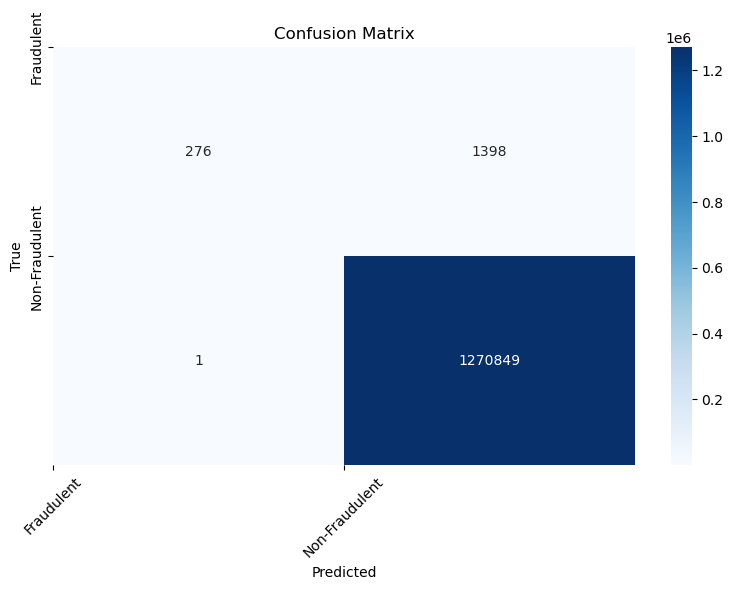

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

# Define the class labels (fraudulent and non-fraudulent)
class_labels = ['Fraudulent', 'Non-Fraudulent']
cm = confusion_matrix(y_test, yhat, labels=[1,0])
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

It is clear from matrix that prediction for for non-fradulent cases were almost perfect by the model, but with respect to fradulent cases, it missed more than 3/4th of the true fradulent cases.

__F1-score__

In [41]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270850
           1       1.00      0.16      0.28      1674

    accuracy                           1.00   1272524
   macro avg       1.00      0.58      0.64   1272524
weighted avg       1.00      1.00      1.00   1272524



Confusion matrix's revelation are confirmed by F1 score for 1(i.e fraud cases) & 0(i.e non-fraud cases)

__Log_loss__

In [33]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.006549122464820624